In [72]:
from IPython.display import display

import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

import scipy.optimize
from mosek.fusion import Model, Domain, Expr, ObjectiveSense


In [2]:
def load(file):
    ncols = 5

    with open(file) as fd:
        lines = np.array(fd.read().split(os.linesep))
    cols = np.split(lines, ncols)
    convert = lambda x, y: (x, y) if 'MWh' not in x else (x, pd.to_numeric(y).astype('float64'))
    df = pd.DataFrame(dict(convert(c[0], c[1:]) for c in cols))
    return df

In [3]:
demand = load('demand.txt')
ndemand = len(demand)
display(demand.head(2))
supply = load('supply.txt')
nsupply = len(supply)
display(supply.head(2))

,Company,id,Amount (MWh),Price (e/MWh),Area
0,CleanRetail,D 1,250.0,200.0,DTU-West
1,El4You,D 2,300.0,110.0,DTU-East


,Company,id,Amount (MWh),Price (e/MWh),Area
0,RT R,G 1,120.0,0.0,DTU-West
1,WeTrustInWind,G 2,50.0,0.0,DTU-East


In [4]:
c = np.concatenate([supply['Amount (MWh)'], -1 * demand['Amount (MWh)']])

In [5]:
A_eq = [np.concatenate([np.ones(nsupply), -1 * np.ones(ndemand)])]
b_eq = [0]

In [6]:
ub = np.concatenate([supply['Price (e/MWh)'], demand['Price (e/MWh)']])

In [7]:
res = scipy.optimize.linprog(c=c, A_eq=A_eq, b_eq=b_eq, bounds=[(0, x) for x in ub])
res

     con: array([-3.4156521e-11])
     fun: -77739.99999703633
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([0.00000000e+00, 0.00000000e+00, 2.48762908e-11, 7.69827622e-12,
       1.83096105e+01, 3.40000000e+01, 2.05656547e+01, 6.07316672e-11,
       2.91403590e-10, 4.00000000e+01, 4.58043851e-11, 7.00000000e+01,
       1.00000000e+02, 1.15781083e+02, 2.00000000e+02, 2.00000000e+02,
       1.10000000e+02, 1.00000000e+02, 9.00000000e+01, 2.16864730e-11,
       7.50000000e+01, 2.36563482e+01, 3.21346067e-11, 2.69158327e-11,
       2.96186731e-11, 2.91157418e-11, 2.80852849e-11])

In [8]:
with Model('power') as M:
    yD = M.variable('yD', ndemand, Domain.inRange(0, demand['Amount (MWh)'].values))
    yG = M.variable('yG', nsupply, Domain.inRange(0, supply['Amount (MWh)'].values))
    lambdaD = demand['Price (e/MWh)'].values
    lambdaG = supply['Price (e/MWh)'].values
    eq = M.constraint('eq', Expr.sub(Expr.sum(yG), Expr.sum(yD)), Domain.equalsTo(0.))
    
    obj = Expr.sub(Expr.dot(lambdaG, yG), Expr.dot(lambdaD, yD))
    M.objective('obj', ObjectiveSense.Minimize, obj)
    M.solve()
    
    demand['D (MWh)'] = yD.level()
    supply['G (MWh)'] = yG.level()
    price = eq.dual()[0]

In [70]:
display(demand)
display(supply)
print('Clearing price: {:g}'.format(price))
print('Energy scheduled: {:g}'.format(demand['D (MWh)'].sum()))

,Company,id,Amount (MWh),Price (e/MWh),Area,D (MWh)
0,CleanRetail,D 1,250.0,200.0,DTU-West,250.0
1,El4You,D 2,300.0,110.0,DTU-East,300.0
2,EVcharge,D 3,120.0,100.0,DTU-West,120.0
3,QualiWatt,D 4,80.0,90.0,DTU-East,80.0
4,IntelliWatt,D 5,40.0,85.0,DTU-West,40.0
5,El4You,D 6,70.0,75.0,DTU-West,70.0
6,CleanRetail,D 7,60.0,65.0,DTU-East,60.0
7,IntelliWatt,D 8,45.0,40.0,DTU-West,45.0
8,QualiWatt,D 9,30.0,38.0,DTU-West,30.0
9,IntelliWatt,D 10,35.0,31.0,DTU-East,0.0


,Company,id,Amount (MWh),Price (e/MWh),Area,G (MWh)
0,RT R,G 1,120.0,0.0,DTU-West,120.0
1,WeTrustInWind,G 2,50.0,0.0,DTU-East,50.0
2,BlueHydro,G 3,200.0,15.0,DTU-West,200.0
3,RT R,G 4,400.0,30.0,DTU-East,400.0
4,KøbenhavnCHP,G 5,60.0,32.5,DTU-West,60.0
5,KøbenhavnCHP,G 6,50.0,34.0,DTU-East,30.0
6,KøbenhavnCHP,G 7,60.0,36.0,DTU-West,60.0
7,DirtyPower,G 8,100.0,37.5,DTU-West,75.0
8,DirtyPower,G 9,70.0,39.0,DTU-West,0.0
9,DirtyPower,G 10,50.0,40.0,DTU-West,-0.0


Clearing price: 37.5
Energy scheduled: 995


In [64]:
regions = ['DTU-East', 'DTU-West']
interconnects = [('DTU-East', 'DTU-West', 40.)]
# interconnects = []

with Model('power') as M:
    yD = M.variable('yD', ndemand, Domain.inRange(0, demand['Amount (MWh)'].values))
    yG = M.variable('yG', nsupply, Domain.inRange(0, supply['Amount (MWh)'].values))
    lambdaD = demand['Price (e/MWh)'].values
    lambdaG = supply['Price (e/MWh)'].values
    total = M.constraint('total', Expr.sub(Expr.sum(yG), Expr.sum(yD)), Domain.equalsTo(0.))

    icVars = [M.variable(':'.join((src, dst)), 1, Domain.inRange(-cap, cap)) 
              for src, dst, cap in interconnects]
    reg_totals = []
    for region in regions:
        yDreg = yD.pick(np.where(demand['Area'] == region)[0].astype('int32'))
        yGreg = yG.pick(np.where(supply['Area'] == region)[0].astype('int32'))
        reg_sum = Expr.sub(Expr.sum(yGreg), Expr.sum(yDreg))
        for (src, dst, cap), var in zip(interconnects, icVars):
            if src == region:
                reg_sum = Expr.sub(reg_sum, var)
            elif dst == region:
                reg_sum = Expr.add(reg_sum, var)
        reg_total = M.constraint(region, reg_sum, Domain.equalsTo(0.))
        reg_totals.append(reg_total)
    
    obj = Expr.sub(Expr.dot(lambdaG, yG), Expr.dot(lambdaD, yD))
    M.objective('obj', ObjectiveSense.Minimize, obj)
    M.solve()
    
    demand['D (MWh)'] = yD.level()
    supply['G (MWh)'] = yG.level()
    prices = {r: t.dual()[0] for r, t in zip(regions, reg_totals)}
    

In [65]:
pd.DataFrame({'demand': demand.groupby('Area')['D (MWh)'].sum(),
              'supply': supply.groupby('Area')['G (MWh)'].sum(),
              'price': prices})

,demand,supply,price
Area,,,
DTU-East,440.0,480.0,34.0
DTU-West,555.0,515.0,37.5


In [69]:
'Congestion rent: {:g}'.format((demand['D (MWh)'] * demand['Area'].map(prices)).sum() - 
                               (supply['G (MWh)'] * supply['Area'].map(prices)).sum())

'Congestion rent: 140'

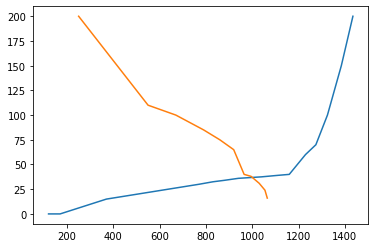

In [79]:
plt.plot(supply['Amount (MWh)'].cumsum(), supply['Price (e/MWh)'])
plt.plot(demand['Amount (MWh)'].sort_index(ascending=True).cumsum().sort_index(),
         demand['Price (e/MWh)']
        )